In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def rk4(x_init: np.ndarray, t_init: float, dt: float, f):
   '''
   Integrates the dynamics of `x_dot = f(x, t)` over a time interval `dt` given an initial state, `x_init`, and time, `t_init`
   using the RK4 algorithm.
   Returns the state at the end of the time interval `dt`.

   - x_init = Initial system state
   - t_init = Initial time
   - dt = Time interval over which `f` is integrated
   - f = f(t, x) - the function representing the time derivative of the state vector, `x`
   '''
   k1 = f(t_init, x_init)
   k2 = f(t_init + dt/2, x_init + dt * k1/2)
   k3 = f(t_init + dt/2, x_init + dt * k2/2)
   k4 = f(t_init + dt, x_init + dt * k3)

   return x_init + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)


In [3]:
def z_dot_dubins(z: np.ndarray, u: np.ndarray):
    '''
    z : [x, y, theta]
        x_pos, y_pos, orientation
        State of dynamical system
    u : [v, w]
        commanded speed, commanded angular velocity
        Control input for dynamical system
    Returns z_dot = f(z, u)
    '''
    z_dot = [u[0] * np.cos(z[2]), u[0] * np.sin(z[2]), u[1]]
    return np.array(z_dot)

In [4]:
def V_dubins(z: np.ndarray, z_target: np.ndarray, A: np.ndarray):
    '''
    z : [x, y, theta]
        x_pos, y_pos, orientation
        State of dynamical system
    z_target : [x, y, theta]
        x_pos, y_pos, orientation
        Desired state of dynamical system
    A: 3x3 symmetric PSD matrix
    Returns the Lyapunov function of a Dubins vehicle in some state `z`.
    '''
    e = z - z_target
    # A = np.eye(3)
    return 0.5 * np.dot(np.dot(e, A), e)

In [5]:
def V_dot_dubins(z: np.ndarray, z_target: np.ndarray, A: np.ndarray):
    '''
    z : [x, y, theta]
        x_pos, y_pos, orientation
        State of dynamical system
    z_target : [x, y, theta]
        x_pos, y_pos, orientation
        Desired state of dynamical system
    A: 3x3 symmetric PSD matrix
    Returns the Lyapunov function of a Dubins vehicle in some state `z`.
    '''
    e = z - z_target
    # A = np.eye(3)
    return 0.5 * np.dot(np.dot(e, A), e)

In [6]:
def G_dubins(z: np.ndarray):
    '''
    z : [x, y, theta]
        x_pos, y_pos, orientation
        State of dynamical system
    Dubins can be written as
      z_dot = f(z) + G(z) * u
    with f(z) = 0 and G(z) in R^(3, 2)
    '''
    return np.array([[np.cos(z[2]), 0], [np.sin(z[2]), 0], [0, 1]])

In [7]:
def control_dubins(z: np.ndarray, z_target: np.ndarray, A: np.ndarray, gamma: float, p: float):
    '''
    z : [x, y, theta]
        x_pos, y_pos, orientation
        State of dynamical system
    z_target: [x, y, theta]
        Desired state of dynamical system
    gamma: exponential stabilization parameter > 0
    p : slack variable > 0
    '''
    error = (z - z_target)
    inner_val = np.dot(np.transpose(G_dubins(z)) @ A, error)
    if V_dubins(z, z_target, A) <= 0.0:
        return 0.0

    return -gamma * V_dubins(z, z_target, A) * inner_val / (1/p + np.dot(inner_val, inner_val))

In [8]:
a = np.array([1, 2, 3])
B = np.array([[1, 0, 0],[1, 2, 0],[0, 2.0, -3.0]])
np.dot(a, B)

array([ 3., 10., -9.])

In [9]:
np.dot(np.transpose(B), a)

array([ 3., 10., -9.])

In [10]:
def make_regulated_dubins(z_target: np.ndarray, A: np.ndarray, gamma: float = 5.0, p: float = 10.0):
    f = lambda t, z: z_dot_dubins(z, control_dubins(z, z_target, A, gamma, p))
    return f

In [11]:
def slack_dubins(z : np.ndarray, z_target: np.ndarray, A: np.ndarray, gamma: float, p: float):
    error = (z - z_target)
    inner_val = np.dot(np.transpose(G_dubins(z)) @ A, error)
    return gamma * V_dubins(z, z_target, A) / (1 + p * np.dot(inner_val, inner_val))

In [28]:
gamma = 1.0
p = 100.0
dt = 0.01
states = []
slacks = []
z_init = np.array([-10, 10, np.pi/4])
states.append(z_init)
A = np.array([[10, 0.0, 1.0], [0.0, 10.0, 1], [1., 1., 0.0]])
z_target = np.zeros(3)
f = make_regulated_dubins(z_target, A, gamma, p)
for i in range(3000):
    z = rk4(states[-1], 0.0, dt, f)
    slacks.append(slack_dubins(states[-1], np.zeros(3), A, 2.0, 1000.))
    states.append(z)

Text(0.5, 1.0, 'trajectory')

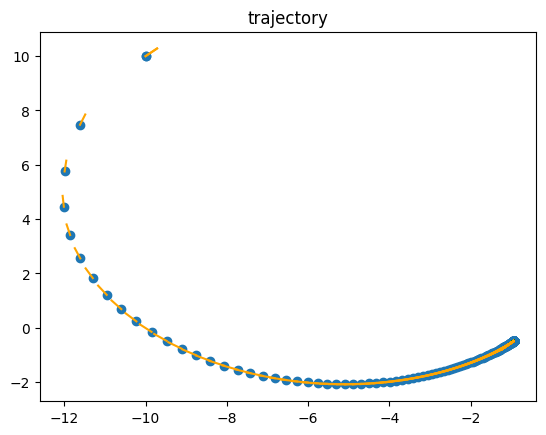

In [29]:
pruned_states = [x for i, x in enumerate(states) if i % 8 == 0]
pruned_states.append(states[-1])
pruned_states.insert(0, states[0])

arrows = [[(x[0], x[1]), (x[0] + 0.4 * np.cos(x[2]), x[1] + 0.4 * np.sin(x[2]))] for x in pruned_states]

# plt.plot([x[0] for x in states], [x[1] for x in states])
plt.scatter([x[0] for x in pruned_states], [x[1] for x in pruned_states])
for arrow in arrows:
    plt.plot([a[0] for a in arrow], [a[1] for a in arrow], color='orange')
plt.title("trajectory")

Text(0.5, 1.0, 'inputs')

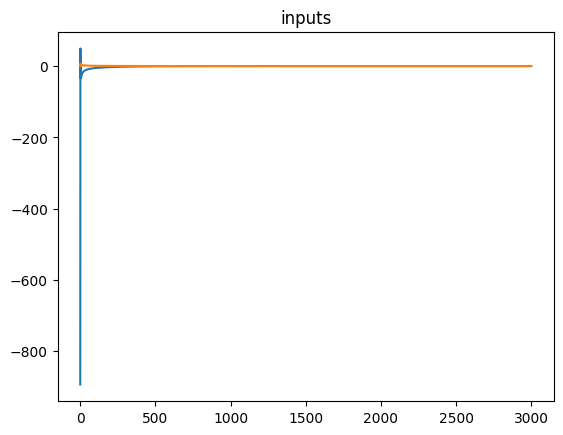

In [30]:
inputs = [control_dubins(z, z_target, A, gamma, p) for z in states]
plt.plot(inputs)
plt.title("inputs")

Text(0.5, 1.0, 'slacks')

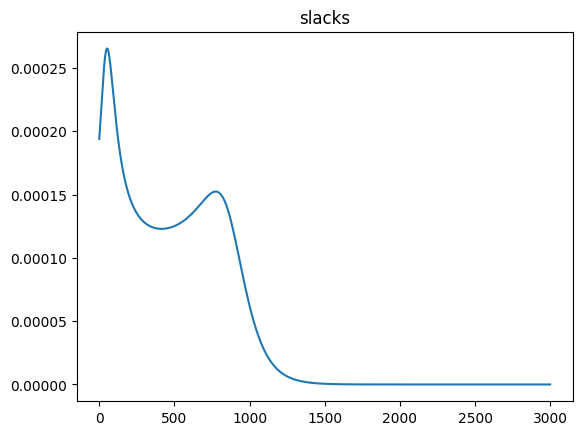

In [19]:
plt.plot(slacks)
plt.title("slacks")